In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba
import warnings
warnings.filterwarnings('ignore')

# Add the root directory of the package to sys.path
sys.path.append('/Users/zzhang/Workspace/SpyDust/')
sys.path.append('../')

# Configure matplotlib for publication quality
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif', 'serif'],
    'text.usetex': False,  # Set to True if LaTeX is available
    'figure.figsize': [10, 8],
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.format': 'pdf',
    'axes.linewidth': 1.2,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6
})

# Check which font is actually being used
import matplotlib.font_manager as fm
font_prop = fm.FontProperties(family='serif')
print(f"Active serif font: {font_prop.get_name()}")
print(f"Available serif fonts: {[f.name for f in fm.fontManager.ttflist if 'serif' in f.name.lower()][:5]}")  # Show first 5

# Import SpyDust modules
import functools
import SpyDust.Grain as Grain
from SpyDust.SpyDust import SpyDust_given_grain_size_shape
from SpyDust.util import makelogtab, cgsconst
from SpyDust.SPDUST_as_is import emissivity
import matplotlib.cm as cm

from SpyDust.SED_fit import fit_sed_ensemble
# from mcpost import gsa_pipeline


Active serif font: Times New Roman
Available serif fonts: ['DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'DejaVu Serif']


In [2]:
freqs = np.loadtxt('data/freq.txt')
MC_key_params = np.loadtxt('data/MC_key_params.txt')
MC_sed_key_params = np.loadtxt('data/MC_SED_key_params.txt')
# Remove unphysical SEDs (nan or negative values)
valid_indices_MC = ~np.isnan(MC_sed_key_params).any(axis=1) & (MC_sed_key_params > 0).all(axis=1)
MC_key_params = MC_key_params[valid_indices_MC]
MC_sed_key_params = MC_sed_key_params[valid_indices_MC]

DC_key_params = np.loadtxt('data/DC_key_params.txt')
DC_sed_key_params = np.loadtxt('data/DC_SED_key_params.txt')
# Remove unphysical SEDs (nan or negative values)
valid_indices_DC = ~np.isnan(DC_sed_key_params).any(axis=1) & (DC_sed_key_params > 0).all(axis=1)
DC_key_params = DC_key_params[valid_indices_DC]
DC_sed_key_params = DC_sed_key_params[valid_indices_DC]

HII_key_params = np.loadtxt('data/HII_key_params.txt')
HII_sed_key_params = np.loadtxt('data/HII_SED_key_params.txt')
# Remove unphysical SEDs (nan or negative values)
valid_indices_HII = ~np.isnan(HII_sed_key_params).any(axis=1) & (HII_sed_key_params > 0).all(axis=1)
HII_key_params = HII_key_params[valid_indices_HII]
HII_sed_key_params = HII_sed_key_params[valid_indices_HII]

In [5]:
from scipy.stats import gaussian_kde
from concurrent.futures import ThreadPoolExecutor
from tqdm.auto import tqdm

def monte_carlo_integral(params, data, p_target, q_sample=None):
    """
    Estimate integral of f(theta) over parameter space with target distribution p_target,
    using samples and importance sampling. If the sampling density q_sample is not provided,
    it is estimated from the samples using KDE.

    Parameters
    ----------
    params : np.ndarray, shape (N_samples, N_params)
        Sample points in the parameter space.
    data : np.ndarray, shape (N_samples, N_data)
        Function values at the sample points.
    p_target : callable
        Target probability density function p(theta), evaluated at each sample.
    q_sample : callable or None
        Sampling probability density function q(theta), evaluated at each sample.
        If None, estimated via KDE from params.

    Returns
    -------
    integral : np.ndarray, shape (N_data,)
        Estimated integral over parameter space.
    """
    params = np.asarray(params)
    data = np.asarray(data)

    p_vals = np.asarray(p_target(params))

    if q_sample is None:
        kde = gaussian_kde(params.T)
        q_vals = kde(params.T)
    else:
        q_vals = np.asarray(q_sample(params))

    weights = p_vals / q_vals
    weights_sum = np.sum(weights)
    if weights_sum == 0:
        raise ValueError("Importance weights sum to zero; cannot normalize.")
    weights /= weights_sum

    integral = np.sum(weights[:, None] * data, axis=0)
    return integral

def monte_carlo_Dirichlet_ensemble(params, data, p_target=None, q_sample=None, N_ensemble=10, alpha=1.0, show_progress=True):
    """
    Compute multiple ensemble integrals over saved samples using random weights.

    Parameters
    ----------
    params : np.ndarray, shape (N_samples, 3)
        Sample points in the 3D parameter space.
    data : np.ndarray, shape (N_samples, N_data)
        Function values at the sample points.
    p_target : callable or None
        Target probability density function p(theta). If None, uniform is assumed.
    q_sample : callable or None
        Sampling PDF q(theta). If None, KDE is used to estimate it.
    N_ensemble : int
        Number of ensemble realizations to generate.
    alpha : float
        Concentration parameter for the Dirichlet draw.
    show_progress : bool
        If True, display a tqdm progress bar for the ensemble loop.

    Returns
    -------
    ensemble_integrals : np.ndarray, shape (N_ensemble, N_data)
        Array of ensemble-integrated data.
    """
    params = np.asarray(params)
    data = np.asarray(data)
    N_samples = len(params)
    
    if N_samples == 0:
        raise ValueError("monte_carlo_ensemble received zero samples.")
    
    if p_target is None:
        p_vals = np.ones(N_samples)
    else:
        p_vals = np.asarray(p_target(params))
    
    if q_sample is None:
        kde = gaussian_kde(params.T)
        q_vals = kde(params.T)
    else:
        q_vals = np.asarray(q_sample(params))
    
    if np.any(q_vals <= 0):
        raise ValueError("Sampling PDF q(theta) must be strictly positive on the provided samples.")
    
    base_weights = p_vals / q_vals
    base_weights = np.clip(base_weights, 0.0, None)
    weight_sum = np.sum(base_weights)
    if weight_sum == 0:
        raise ValueError("All importance weights are zero; cannot form ensemble.")
    base_weights /= weight_sum
    
    positive_mask = base_weights > 0
    dirichlet_alpha = base_weights[positive_mask] * alpha
    if dirichlet_alpha.size == 0:
        raise ValueError("No positive weights remain after filtering; cannot draw from Dirichlet.")
    
    ensemble_integrals = []
    iterator = tqdm(range(N_ensemble), desc="Sampling ensembles", leave=False, disable=not show_progress)
    for _ in iterator:
        random_weights = np.zeros_like(base_weights)
        random_weights[positive_mask] = np.random.dirichlet(dirichlet_alpha)
        weighted_sum = np.sum(random_weights[:, None] * data, axis=0)
        ensemble_integrals.append(weighted_sum)
    
    return np.array(ensemble_integrals)

In [ ]:
from tqdm.auto import tqdm
import SpyDust.Grain as Grain


def grain_size_dist(gamma, log_a0, sigma, log_beta0, delta, log_p_c, log_p_width):
    """
    dn/da propto exp[(gamma - 1) lna - 1/2 ((ln(a) - ln(a0) + sigma**2/2)^2 / sigma^2)]
    """
    def dist_func(theta):
        a, beta, p = theta[:, 0], theta[:, 1], theta[:, 2]
        ln_a_list = np.log(a)
        exponent_a = (gamma-1)  * ln_a_list - 0.5 * ( (ln_a_list - log_a0 + sigma**2/2) / sigma ) ** 2
        
        ln_beta_t_tab = np.log( beta + 0.5 )
        exponent_beta = - ln_beta_t_tab - 0.5 * ( (ln_beta_t_tab  - log_beta0 + delta**2/2 ) / delta ) ** 2

        log_p = np.log(p)  
        exponent_env = - log_p - 0.5 * ( (log_p  - log_p_c + log_p_width**2/2 ) / log_p_width ) ** 2

        exponent = exponent_a + exponent_beta + exponent_env

        max_exponent = np.max(exponent)
        exponent -= max_exponent
        weights = np.exp(exponent)
        return weights
    return dist_func

def _integral_task(args):
    dist_params, X_arr, Y_arr = args
    gamma, log_a0, sigma, log_beta0, delta, log_p_c, log_p_width = dist_params
    p_target = grain_size_dist(gamma, log_a0, sigma, log_beta0, delta, log_p_c, log_p_width)
    return monte_carlo_integral(X_arr, Y_arr, p_target=p_target, q_sample=None)

class ensemble_model:
    gamma_min = -3.0
    gamma_max = 3.0

    log_a0_min = np.log(1e-9) 
    log_a0_max = np.log(1e-6)

    sigma_min = 0.01
    sigma_max = 20.0

    log_beta0_min = np.log(0.05)
    log_beta0_max = np.log(2)

    delta_min = 0.001
    delta_max = 20.0
    
    log_p_width_min = 0.001
    log_p_width_max = 20.0

    def __init__(self, log_p_c_min, log_p_c_max):
        self.log_p_c_min = log_p_c_min
        self.log_p_c_max = log_p_c_max

    def generate_params_samples(self, N_samples):
        gamma_list = np.random.uniform(self.gamma_min, self.gamma_max, N_samples)
        log_a0_list = np.random.uniform(self.log_a0_min, self.log_a0_max, N_samples)
        sigma_list = np.random.uniform(self.sigma_min, self.sigma_max, N_samples)
        log_beta0_list = np.random.uniform(self.log_beta0_min, self.log_beta0_max, N_samples)
        delta_list = np.random.uniform(self.delta_min, self.delta_max, N_samples)
        log_p_c_list = np.random.uniform(self.log_p_c_min, self.log_p_c_max, N_samples)
        log_p_width_list = np.random.uniform(self.log_p_width_min, self.log_p_width_max, N_samples)

        params = np.vstack([
            gamma_list,
            log_a0_list,
            sigma_list,
            log_beta0_list,
            delta_list,
            log_p_c_list,
            log_p_width_list
        ]).T
        return params
    
    def analysis(self, X_arr, Y_arr, num_samples=1000, max_workers=None, show_progress=True):
        X_arr = np.asarray(X_arr)
        Y_arr = np.asarray(Y_arr)

        params = self.generate_params_samples(num_samples)
        
        if max_workers is None:
            cpu_count = os.cpu_count() or 1
            max_workers = min(32, cpu_count)

        tasks = ((params[i], X_arr, Y_arr) for i in range(num_samples))
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            iterator = executor.map(_integral_task, tasks)
            if show_progress:
                iterator = tqdm(iterator, total=num_samples, desc="Evaluating ensembles", leave=False)
            results = list(iterator)
        
        return params, np.asarray(results)




In [7]:
N_samples = 5000

MC_dist_model = ensemble_model(log_p_c_min=np.log(1e-6), log_p_c_max=np.log(1e-2))
MC_dist_ensem_params, MC_dist_ensem_sed = MC_dist_model.analysis(MC_key_params[:, [6,7,4]], MC_sed_key_params, num_samples=N_samples, max_workers=30, show_progress=True)
MC_dist_ensem_features = fit_sed_ensemble(
    freqs, 
    MC_dist_ensem_sed, 
    thres=1e-3, 
    v2=False
)
MC_dist_ensem_features[:, 0] = np.exp(MC_dist_ensem_features[:, 0])


100%|██████████| 5000/5000 [00:00<00:00, 5486.68it/s]                         


Evaluating ensembles:   3%|▎         | 127/5000 [01:08<16:55,  4.80it/s]

In [8]:
N_samples = 5000

DC_dist_model = ensemble_model(log_p_c_min=np.log(1e-8), log_p_c_max=np.log(1e-4))
DC_dist_ensem_params, DC_dist_ensem_sed = DC_dist_model.analysis(DC_key_params[:, [6,7,4]], DC_sed_key_params, num_samples=N_samples, max_workers=30, show_progress=True)
DC_dist_ensem_features = fit_sed_ensemble(
    freqs, 
    DC_dist_ensem_sed, 
    thres=1e-3, 
    v2=False
)
DC_dist_ensem_features[:, 0] = np.exp(DC_dist_ensem_features[:, 0])

100%|██████████| 5000/5000 [00:01<00:00, 4613.09it/s]                      


In [ ]:
N_samples = 5000

HII_dist_model = ensemble_model(log_p_c_min=np.log(1.), log_p_c_max=np.log(1e5))
HII_dist_ensem_params, HII_dist_ensem_sed = HII_dist_model.analysis(HII_key_params[:, [6,7,0]], HII_sed_key_params, num_samples=N_samples, max_workers=30, show_progress=True)
HII_dist_ensem_features = fit_sed_ensemble(
    freqs, 
    HII_dist_ensem_sed, 
    thres=1e-3, 
)
HII_dist_ensem_features[:, 0] = np.exp(HII_dist_ensem_features[:, 0])

100%|██████████| 5000/5000 [00:01<00:00, 2829.43it/s]                     


In [10]:
# # Save the data
np.savetxt("data/MC_dist_ensem_params.txt", MC_dist_ensem_params)
np.savetxt("data/MC_dist_ensem_sed.txt", MC_dist_ensem_sed)
np.savetxt("data/MC_dist_ensem_features.txt", MC_dist_ensem_features)

np.savetxt("data/DC_dist_ensem_params.txt", DC_dist_ensem_params)
np.savetxt("data/DC_dist_ensem_sed.txt", DC_dist_ensem_sed)
np.savetxt("data/DC_dist_ensem_features.txt", DC_dist_ensem_features)

np.savetxt("data/HII_dist_ensem_params.txt", HII_dist_ensem_params)
np.savetxt("data/HII_dist_ensem_sed.txt", HII_dist_ensem_sed)
np.savetxt("data/HII_dist_ensem_features.txt", HII_dist_ensem_features)

# Load the data
# MC_dist_ensem_params = np.loadtxt("data/MC_dist_ensem_params.txt")
# MC_dist_ensem_sed = np.loadtxt("data/MC_dist_ensem_sed.txt")
# MC_dist_ensem_features = np.loadtxt("data/MC_dist_ensem_features.txt")

# DC_dist_ensem_params = np.loadtxt("data/DC_dist_ensem_params.txt")
# DC_dist_ensem_sed = np.loadtxt("data/DC_dist_ensem_sed.txt")
# DC_dist_ensem_features = np.loadtxt("data/DC_dist_ensem_features.txt")

# HII_dist_ensem_params = np.loadtxt("data/HII_dist_ensem_params.txt")
# HII_dist_ensem_sed = np.loadtxt("data/HII_dist_ensem_sed.txt")
# HII_dist_ensem_features = np.loadtxt("data/HII_dist_ensem_features.txt")

In [44]:
HII_dist_ensem_sed.shape

(5000, 500)

In [45]:
# Generate higher order moments

from SpyDust.SED_fit import measure_sed_log_moments_batch

MC_dist_ensem_moments = measure_sed_log_moments_batch(freqs, MC_dist_ensem_sed, thres=1e-2, excess_kurtosis=True)
DC_dist_ensem_moments = measure_sed_log_moments_batch(freqs, DC_dist_ensem_sed, thres=1e-2, excess_kurtosis=True)
HII_dist_ensem_moments = measure_sed_log_moments_batch(freqs, HII_dist_ensem_sed, thres=1e-2, excess_kurtosis=True)

In [11]:
# Your arrays
# X: (N_samples, N_params)
# Y: (N_samples, 2)  # columns: [peak_frequency, width]
param_names = ["gamma","log_a","sigma","log_beta","delta","log_p","logp_width"]  # adjust to your order

MC_out = gsa_pipeline(
    MC_dist_ensem_params, MC_dist_ensem_features,
    feature_names=["nu_peak", "width"],
    param_names=param_names,
    scaler="standard",            # try "minmax" or None as well
    kernel_kind="rbf",             # try "rbf", "matern32", "matern52", "rq"
    ard=True,
    length_scale_init=1.0,        # or np.ones(d_kept) after dropping consts (handled internally)
    enable_perm=True,
    enable_gp=True,
    enable_sobol=True,
    make_pdp=True,
    N_sobol=1024,                 # increase for tighter Sobol CIs
    drop_const_atol=0.0,
    topk_pdp=3,
    pdp_prefix="pdp_demo",
    gp_random_state=0,
)

table_peak  = MC_out["results"]["nu_peak"]["table"]
table_width = MC_out["results"]["width"]["table"]



In [12]:
from gsa_pipeline import sensitivity_table_to_latex

print(sensitivity_table_to_latex(table_peak, feature_label="peak"))

print(sensitivity_table_to_latex(table_width, feature_label="width"))

\begin{tabular}{llrrrrrrrrrr}
\toprule
Feature & Parameter & MI & dCor & PermMean & PermStd & S1 & S1_conf & ST & ST_conf & 1/ARD_LS & AggRank \\
\midrule
\multirow{7}{*}{peak} & logp\_width & 0.175 & 0.245 & 0.670 & 0.040 & 0.091 & 0.079 & 0.415 & 0.076 & 1.283 & 2.000 \\
 & log\_p & 0.096 & 0.300 & 0.749 & 0.066 & 0.096 & 0.066 & 0.346 & 0.074 & 0.568 & 2.600 \\
 & gamma & 1.009 & 0.722 & 0.572 & 0.028 & 0.236 & 0.060 & 0.253 & 0.039 & 0.219 & 3.000 \\
 & sigma & 0.100 & 0.072 & 0.170 & 0.016 & 0.030 & 0.097 & 0.306 & 0.096 & 2.381 & 3.200 \\
 & log\_a & 0.021 & 0.085 & 0.112 & 0.032 & 0.065 & 0.058 & 0.258 & 0.081 & 0.675 & 4.400 \\
 & delta & 0.024 & 0.045 & 0.008 & 0.001 & -0.003 & 0.006 & 0.005 & 0.001 & 0.107 & 5.800 \\
 & log\_beta & 0.000 & 0.032 & 0.002 & 0.001 & 0.004 & 0.003 & 0.002 & 0.000 & 0.038 & 7.000 \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrrrrrrrrr}
\toprule
Feature & Parameter & MI & dCor & PermMean & PermStd & S1 & S1_conf & ST & ST_conf & 1/ARD_LS & AggRa

In [13]:

param_names = ["gamma","log_a","sigma","log_beta","delta","log_p","logp_width"]  # adjust to your order

DC_out = gsa_pipeline(
    DC_dist_ensem_params, DC_dist_ensem_features,
    feature_names=["nu_peak", "width"],
    param_names=param_names,
    scaler="standard",            # try "minmax" or None as well
    kernel_kind="rbf",             # try "rbf", "matern32", "matern52", "rq"
    ard=True,
    length_scale_init=1.0,        # or np.ones(d_kept) after dropping consts (handled internally)
    enable_perm=True,
    enable_gp=True,
    enable_sobol=True,
    make_pdp=True,
    N_sobol=1024,                 # increase for tighter Sobol CIs
    drop_const_atol=0.0,
    topk_pdp=3,
    pdp_prefix="pdp_demo",
    gp_random_state=0,
)

table_peak  = DC_out["results"]["nu_peak"]["table"]
table_width = DC_out["results"]["width"]["table"]

print(sensitivity_table_to_latex(table_peak, feature_label="peak"))

print(sensitivity_table_to_latex(table_width, feature_label="width"))

\begin{tabular}{llrrrrrrrrrr}
\toprule
Feature & Parameter & MI & dCor & PermMean & PermStd & S1 & S1_conf & ST & ST_conf & 1/ARD_LS & AggRank \\
\midrule
\multirow{7}{*}{peak} & sigma & 0.102 & 0.131 & 0.779 & 0.089 & 0.114 & 0.222 & 0.747 & 0.153 & 7.818 & 2.000 \\
 & logp\_width & 0.108 & 0.183 & 0.338 & 0.029 & 0.025 & 0.040 & 0.191 & 0.041 & 1.458 & 2.800 \\
 & gamma & 1.424 & 0.746 & 0.520 & 0.039 & 0.118 & 0.046 & 0.162 & 0.040 & 0.422 & 3.000 \\
 & log\_a & 0.019 & 0.115 & 0.742 & 0.177 & 0.053 & 0.072 & 0.589 & 0.212 & 1.164 & 3.600 \\
 & log\_p & 0.050 & 0.203 & 0.260 & 0.027 & 0.013 & 0.028 & 0.146 & 0.035 & 0.539 & 4.200 \\
 & delta & 0.038 & 0.077 & 0.042 & 0.005 & -0.008 & 0.021 & 0.050 & 0.023 & 0.577 & 5.400 \\
 & log\_beta & 0.002 & 0.048 & 0.021 & 0.006 & 0.009 & 0.012 & 0.010 & 0.003 & 0.165 & 7.000 \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrrrrrrrrr}
\toprule
Feature & Parameter & MI & dCor & PermMean & PermStd & S1 & S1_conf & ST & ST_conf & 1/ARD_LS & AggRa

In [14]:

param_names = ["gamma","log_a","sigma","log_beta","delta","log_p","logp_width"]  # adjust to your order

HII_out = gsa_pipeline(
    HII_dist_ensem_params, HII_dist_ensem_features,
    feature_names=["nu_peak", "width"],
    param_names=param_names,
    scaler="standard",            # try "minmax" or None as well
    kernel_kind="rbf",             # try "rbf", "matern32", "matern52", "rq"
    ard=True,
    length_scale_init=1.0,        # or np.ones(d_kept) after dropping consts (handled internally)
    enable_perm=True,
    enable_gp=True,
    enable_sobol=True,
    make_pdp=True,
    N_sobol=1024,                 # increase for tighter Sobol CIs
    drop_const_atol=0.0,
    topk_pdp=3,
    pdp_prefix="pdp_demo",
    gp_random_state=0,
)

table_peak  = HII_out["results"]["nu_peak"]["table"]
table_width = HII_out["results"]["width"]["table"]

print(sensitivity_table_to_latex(table_peak, feature_label="peak"))

print(sensitivity_table_to_latex(table_width, feature_label="width"))

\begin{tabular}{llrrrrrrrrrr}
\toprule
Feature & Parameter & MI & dCor & PermMean & PermStd & S1 & S1_conf & ST & ST_conf & 1/ARD_LS & AggRank \\
\midrule
\multirow{7}{*}{peak} & logp\_width & 0.382 & 0.455 & 1.346 & 0.071 & 0.264 & 0.109 & 0.789 & 0.134 & 2.859 & 1.000 \\
 & log\_p & 0.378 & 0.447 & 1.103 & 0.100 & 0.169 & 0.086 & 0.660 & 0.174 & 1.132 & 2.200 \\
 & sigma & 0.078 & 0.052 & 0.031 & 0.004 & 0.025 & 0.049 & 0.079 & 0.033 & 1.522 & 3.600 \\
 & gamma & 0.153 & 0.159 & 0.019 & 0.003 & 0.010 & 0.011 & 0.017 & 0.006 & 0.180 & 4.400 \\
 & log\_a & 0.005 & 0.048 & 0.020 & 0.005 & 0.033 & 0.056 & 0.089 & 0.071 & 0.723 & 4.800 \\
 & delta & 0.042 & 0.052 & 0.001 & 0.002 & 0.003 & 0.008 & 0.016 & 0.007 & 0.275 & 5.200 \\
 & log\_beta & 0.005 & 0.043 & -0.002 & 0.003 & 0.001 & 0.005 & 0.004 & 0.002 & 0.091 & 6.800 \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrrrrrrrrr}
\toprule
Feature & Parameter & MI & dCor & PermMean & PermStd & S1 & S1_conf & ST & ST_conf & 1/ARD_LS & AggRa

In [3]:
# Load the catalogues
MC_catalogue = np.loadtxt("data/MC_catalogue.txt")
DC_catalogue = np.loadtxt("data/DC_catalogue.txt")
HII_catalogue = np.loadtxt("data/HII_catalogue.txt")

In [4]:
# Calculate mean and variance for each catalogue
catalogues = {
    "MC": MC_catalogue,
    "DC": DC_catalogue,
    "HII": HII_catalogue,
}

for name, cat in catalogues.items():
    nu_peak = cat[:, 0]
    width = cat[:, 1]
    
    print(f"=== {name} Catalogue ===")
    print(f"  ν_peak: mean = {np.mean(nu_peak):.3f} GHz, var = {np.var(nu_peak):.3f}, std = {np.std(nu_peak):.3f}")
    print(f"  Width:  mean = {np.mean(width):.3f}, var = {np.var(width):.3f}, std = {np.std(width):.3f}")
    print(f"  N samples: {len(cat)}")
    print()

=== MC Catalogue ===
  ν_peak: mean = 21.975 GHz, var = 18.046, std = 4.248
  Width:  mean = 0.592, var = 0.011, std = 0.106
  N samples: 20

=== DC Catalogue ===
  ν_peak: mean = 21.178 GHz, var = 10.195, std = 3.193
  Width:  mean = 0.590, var = 0.012, std = 0.108
  N samples: 40

=== HII Catalogue ===
  ν_peak: mean = 30.493 GHz, var = 160.528, std = 12.670
  Width:  mean = 0.632, var = 0.009, std = 0.097
  N samples: 14



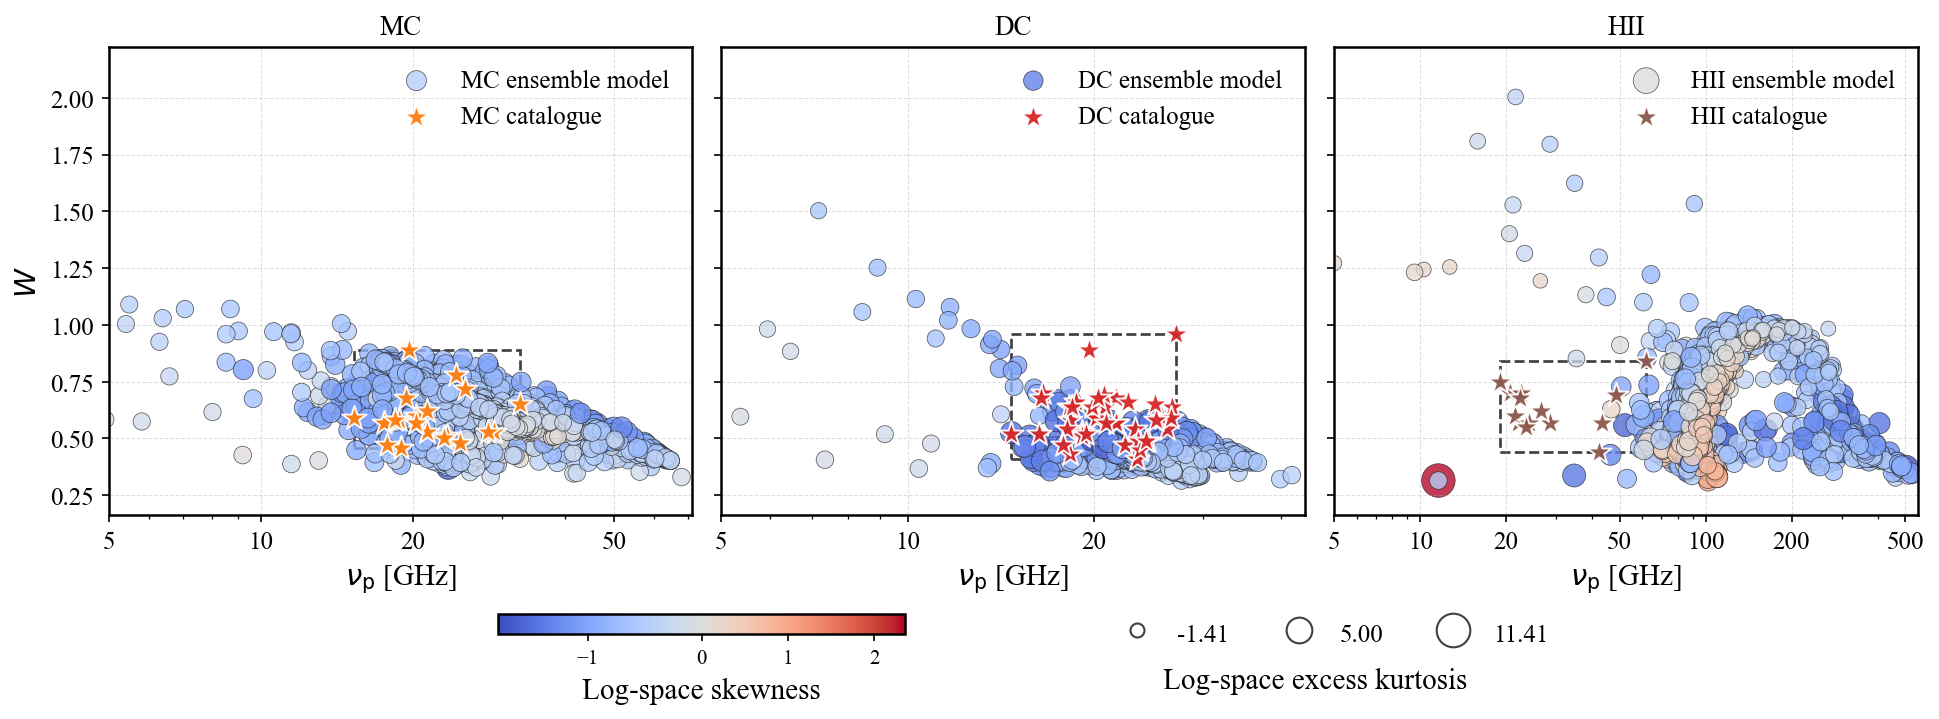

In [135]:
# Compare ensemble fits to catalogue measurements with log-moment annotations
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, NullFormatter, FuncFormatter


fig, axes = plt.subplots(1, 3, figsize=(13.4, 4.4), sharey=True)
axes = np.atleast_1d(axes)

selection_masks = {}

scatter_configs = [
    ("MC", MC_dist_ensem_features, MC_dist_ensem_moments, MC_catalogue, cm.tab10(0), cm.tab10(1)),
    ("DC", DC_dist_ensem_features, DC_dist_ensem_moments, DC_catalogue, cm.tab10(2), cm.tab10(3)),
    ("HII", HII_dist_ensem_features, HII_dist_ensem_moments, HII_catalogue, cm.tab10(4), cm.tab10(5)),
]

# Global ranges for consistent color and size scales
skew_all = np.concatenate([cfg[2][:, 2] for cfg in scatter_configs])
skew_finite = skew_all[np.isfinite(skew_all)]
skew_min, skew_max = np.min(skew_finite), np.max(skew_finite)
if np.isclose(skew_min, skew_max):
    skew_max = skew_min + 1e-6
if skew_min < 0 < skew_max:
    skew_norm = TwoSlopeNorm(vmin=skew_min, vcenter=0.0, vmax=skew_max)
    cmap_name = "coolwarm"
else:
    skew_norm = Normalize(vmin=skew_min, vmax=skew_max)
    cmap_name = "plasma"

kurt_all = np.concatenate([cfg[2][:, 3] for cfg in scatter_configs])
kurt_finite = kurt_all[np.isfinite(kurt_all)]
kurt_min, kurt_max = np.min(kurt_finite), np.max(kurt_finite)
if np.isclose(kurt_min, kurt_max):
    kurt_max = kurt_min + 1e-6
size_range = (45.0, 260.0)
def _scale_marker_size(values):
    finite = np.clip(values, kurt_min, kurt_max)
    return np.interp(finite, [kurt_min, kurt_max], size_range)

if np.isclose(kurt_min, kurt_max):
    size_ticks = np.array([kurt_min])
else:
    size_ticks = np.linspace(kurt_min, kurt_max, 3)

for ax, (label, ensemble_feats, ensemble_moments, catalogue_feats, ensemble_color, catalogue_color) in zip(axes, scatter_configs):
    ensemble_nu = ensemble_feats[:, 0]
    ensemble_width = ensemble_feats[:, 1]

    ensemble_skewness = ensemble_moments[:, 2]
    ensemble_kurtosis = ensemble_moments[:, 3]

    catalogue_nu = catalogue_feats[:, 0]
    catalogue_width = catalogue_feats[:, 1]

    nu_min, nu_max = catalogue_nu.min(), catalogue_nu.max()
    width_min, width_max = catalogue_width.min(), catalogue_width.max()

    mask = (ensemble_nu >= nu_min) & (ensemble_nu <= nu_max) & (ensemble_width >= width_min) & (ensemble_width <= width_max)
    selection_masks[label] = mask

    ensemble_sizes = _scale_marker_size(ensemble_kurtosis)
    ensemble_scatter = ax.scatter(
        ensemble_nu,
        ensemble_width,
        s=ensemble_sizes,
        c=ensemble_skewness,
        cmap=cmap_name,
        norm=skew_norm,
        alpha=0.78,
        linewidth=0.35,
        edgecolors="0.15",
        zorder=1
    )

    catalogue_scatter = ax.scatter(
        catalogue_nu,
        catalogue_width,
        s=150,
        marker="*",
        color=catalogue_color,
        edgecolors="white",
        linewidth=0.9,
        alpha=0.95,
        zorder=3
    )

    rect = mpatches.Rectangle((nu_min, width_min), nu_max - nu_min, width_max - width_min,
                              facecolor="none", edgecolor="0.25", linewidth=1.3, linestyle="--", zorder=0)
    ax.add_patch(rect)

    ax.set_title(f"{label}", fontsize=13)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
    ax.set_xlim(5, max(ensemble_nu.max(), catalogue_nu.max()) * 1.05)
    ax.set_xscale("log")
    ax.xaxis.set_major_locator(LogLocator(base=10, subs=(1.0, 2.0, 5.0)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda val, _: f"{val:g}" if val > 0 else ""))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(1.0, 10.0)))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xlabel(r"$\nu_{\rm p}$ [GHz]")
    ax.legend(
        [ensemble_scatter, catalogue_scatter],
        [f"{label} ensemble model", f"{label} catalogue"],
        loc="upper right",
        frameon=False
    )



axes[0].set_ylabel(r"$W$")

scalar_mappable = cm.ScalarMappable(norm=skew_norm, cmap=cmap_name)
scalar_mappable.set_array([])
cbar = fig.colorbar(
    scalar_mappable,
    ax=axes,
    orientation='horizontal',
    fraction=0.04,
    pad=0.16
)
cbar.set_label("Log-space skewness", fontsize=14)
cbar.ax.tick_params(labelsize=10)


cbar_box = cbar.ax.get_position()
cbar.ax.set_position([0.10, cbar_box.y0-0.06, 0.55, cbar_box.height])

size_handles = []
for val in size_ticks:
    area = np.interp(val, [kurt_min, kurt_max], size_range)
    marker_size = np.sqrt(area)
    size_handles.append(
        Line2D([], [], marker='o', linestyle='None', markersize=marker_size,
              markerfacecolor='none', markeredgecolor='0.25', markeredgewidth=1.0, label=f"{val:.2f}")
    )
size_legend = fig.legend(
    size_handles,
    [handle.get_label() for handle in size_handles],
    loc="lower right",
    bbox_to_anchor=(0.81, 0.0),
    ncol=len(size_handles),
    columnspacing=1.6,
    frameon=False
)
fig.text(
    0.68,
    size_legend.get_bbox_to_anchor().y0 ,# 0.018,
    "Log-space excess kurtosis",
    ha='center',
    va='top',
    fontsize=14
)
for text in size_legend.get_texts():
    text.set_verticalalignment('top')
    text.set_position((-5, 15))



fig.subplots_adjust(left=0.08, right=0.98, bottom=0.23, top=0.94, wspace=0.05)
plt.savefig("obs_vs_ensemble_model.pdf", bbox_inches="tight")
plt.show()

In [64]:
class ensemble_fixed_beta_env(ensemble_model):
    gamma_min = -3.0
    gamma_max = 3.0

    log_a0_min = np.log(1e-9) 
    log_a0_max = np.log(1e-6)

    sigma_min = 0.01
    sigma_max = 20.0

    log_beta0_min = np.log(0.05)
    log_beta0_max = np.log(0.05)

    delta_min = 0.1
    delta_max = 0.1
    
    log_p_width_min = 0.1
    log_p_width_max = 0.1

N_samples = 5000

MC_dist_model_fixed_beta_env = ensemble_fixed_beta_env(log_p_c_min=np.log(1e-4), log_p_c_max=np.log(1e-4))
MC_dist_ensem_params_fixed_beta_env, MC_dist_ensem_sed_fixed_beta_env = MC_dist_model_fixed_beta_env.analysis(
    MC_key_params[:, [6,7,4]], 
    MC_sed_key_params, 
    num_samples=N_samples, 
    max_workers=30, 
    show_progress=True
)

In [65]:
DC_dist_model_fixed_beta_env = ensemble_fixed_beta_env(log_p_c_min=np.log(1e-6), log_p_c_max=np.log(1e-6))
DC_dist_ensem_params_fixed_beta_env, DC_dist_ensem_sed_fixed_beta_env = DC_dist_model_fixed_beta_env.analysis(
    DC_key_params[:, [6,7,4]], 
    DC_sed_key_params, 
    num_samples=N_samples, 
    max_workers=30, 
    show_progress=True
)

In [66]:
HII_dist_model_fixed_beta_env = ensemble_fixed_beta_env(log_p_c_min=np.log(1e4), log_p_c_max=np.log(1e4))
HII_dist_ensem_params_fixed_beta_env, HII_dist_ensem_sed_fixed_beta_env = HII_dist_model_fixed_beta_env.analysis(
    HII_key_params[:, [6,7,0]], 
    HII_sed_key_params, 
    num_samples=N_samples, 
    max_workers=30, 
    show_progress=True
)

In [67]:
np.savetxt("data/MC_dist_ensem_params_fixed_beta_env.txt", MC_dist_ensem_params_fixed_beta_env)
np.savetxt("data/MC_dist_ensem_sed_fixed_beta_env.txt", MC_dist_ensem_sed_fixed_beta_env)
np.savetxt("data/DC_dist_ensem_params_fixed_beta_env.txt", DC_dist_ensem_params_fixed_beta_env)
np.savetxt("data/DC_dist_ensem_sed_fixed_beta_env.txt", DC_dist_ensem_sed_fixed_beta_env)
np.savetxt("data/HII_dist_ensem_params_fixed_beta_env.txt", HII_dist_ensem_params_fixed_beta_env)
np.savetxt("data/HII_dist_ensem_sed_fixed_beta_env.txt", HII_dist_ensem_sed_fixed_beta_env)

In [20]:
MC_dist_ensem_params_fixed_beta_env = np.loadtxt("data/MC_dist_ensem_params_fixed_beta_env.txt")
MC_dist_ensem_sed_fixed_beta_env = np.loadtxt("data/MC_dist_ensem_sed_fixed_beta_env.txt")
DC_dist_ensem_params_fixed_beta_env = np.loadtxt("data/DC_dist_ensem_params_fixed_beta_env.txt")
DC_dist_ensem_sed_fixed_beta_env = np.loadtxt("data/DC_dist_ensem_sed_fixed_beta_env.txt")
HII_dist_ensem_params_fixed_beta_env = np.loadtxt("data/HII_dist_ensem_params_fixed_beta_env.txt")
HII_dist_ensem_sed_fixed_beta_env = np.loadtxt("data/HII_dist_ensem_sed_fixed_beta_env.txt")

In [83]:
MC_dist_ensem_moments_fixed_beta_env = measure_sed_log_moments_batch(freqs, MC_dist_ensem_sed_fixed_beta_env, thres=1e-2, excess_kurtosis=True)
DC_dist_ensem_moments_fixed_beta_env = measure_sed_log_moments_batch(freqs, DC_dist_ensem_sed_fixed_beta_env, thres=1e-2, excess_kurtosis=True)
HII_dist_ensem_moments_fixed_beta_env = measure_sed_log_moments_batch(freqs, HII_dist_ensem_sed_fixed_beta_env, thres=1e-2, excess_kurtosis=True)


In [ ]:
MC_dist_ensem_features_fixed_beta_env = fit_sed_ensemble(
    freqs, 
    MC_dist_ensem_sed_fixed_beta_env, 
    thres=1e-3, 
)
MC_dist_ensem_features_fixed_beta_env[:, 0] = np.exp(MC_dist_ensem_features_fixed_beta_env[:, 0])

DC_dist_ensem_features_fixed_beta_env = fit_sed_ensemble(
    freqs, 
    DC_dist_ensem_sed_fixed_beta_env, 
    thres=1e-3
)
DC_dist_ensem_features_fixed_beta_env[:, 0] = np.exp(DC_dist_ensem_features_fixed_beta_env[:, 0])

HII_dist_ensem_features_fixed_beta_env = fit_sed_ensemble(
    freqs, 
    HII_dist_ensem_sed_fixed_beta_env, 
    thres=1e-3, 
)
HII_dist_ensem_features_fixed_beta_env[:, 0] = np.exp(HII_dist_ensem_features_fixed_beta_env[:, 0])

100%|██████████| 5000/5000 [00:01<00:00, 4355.02it/s]


In [ ]:
# Generate skewness and kurtosis values


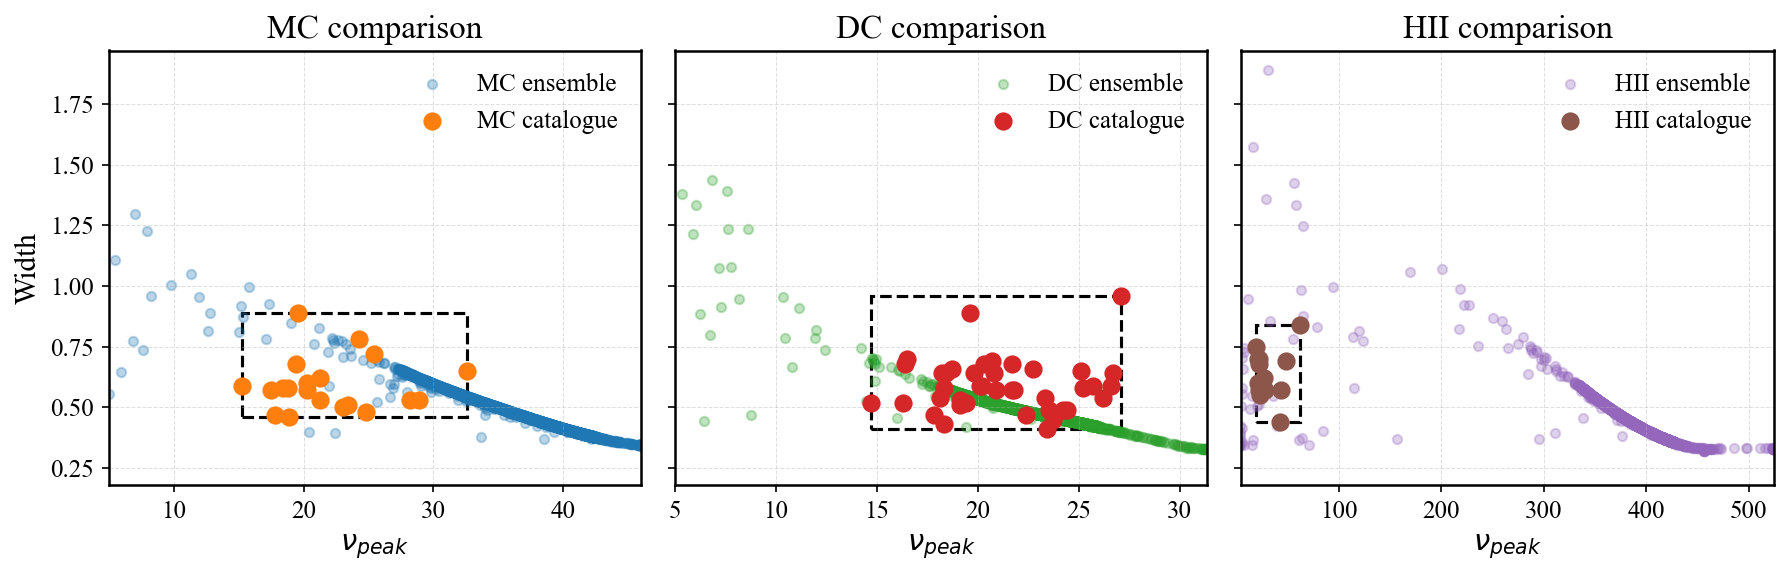

In [40]:
# Compare ensemble fits to catalogue measurements
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=True)
axes = np.atleast_1d(axes)

selection_masks = {}

scatter_configs = [
    ("MC", MC_dist_ensem_features_fixed_beta_env, MC_catalogue, cm.tab10(0), cm.tab10(1)),
    ("DC", DC_dist_ensem_features_fixed_beta_env, DC_catalogue, cm.tab10(2), cm.tab10(3)),
    ("HII", HII_dist_ensem_features_fixed_beta_env, HII_catalogue, cm.tab10(4), cm.tab10(5)),
]

for ax, (label, ensemble_feats, catalogue_feats, ensemble_color, catalogue_color) in zip(axes, scatter_configs):
    ensemble_nu = ensemble_feats[:, 0]
    ensemble_width = ensemble_feats[:, 1]
    catalogue_nu = catalogue_feats[:, 0]
    catalogue_width = catalogue_feats[:, 1]

    nu_min, nu_max = catalogue_nu.min(), catalogue_nu.max()
    width_min, width_max = catalogue_width.min(), catalogue_width.max()
    rect = mpatches.Rectangle((nu_min, width_min), nu_max - nu_min, width_max - width_min,
                              facecolor="none", edgecolor="k", linewidth=1.5, linestyle="--")
    ax.add_patch(rect)

    mask = (ensemble_nu >= nu_min) & (ensemble_nu <= nu_max) & (ensemble_width >= width_min) & (ensemble_width <= width_max)
    selection_masks[label] = mask

    ax.scatter(ensemble_nu, ensemble_width, s=20, alpha=0.3, color=ensemble_color, label=f"{label} ensemble", zorder=1)
    # ax.scatter(ensemble_nu[mask], ensemble_width[mask], s=30, alpha=0.6, color=ensemble_color, label=f"{label} in catalogue", zorder=2)
    ax.scatter(catalogue_nu, catalogue_width, s=60, color=catalogue_color, label=f"{label} catalogue", zorder=3)
    ax.set_title(f"{label} comparison")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
    ax.set_xlim(5, ensemble_nu.max())
    ax.set_xlabel("$\\nu_{peak}$")
    # ax.set_ylabel("Width")
    ax.legend(loc="best", frameon=False)

axes[0].set_ylabel("Width")

plt.tight_layout()
plt.savefig("obs_vs_conditional_ensemble_model.pdf")

plt.show()

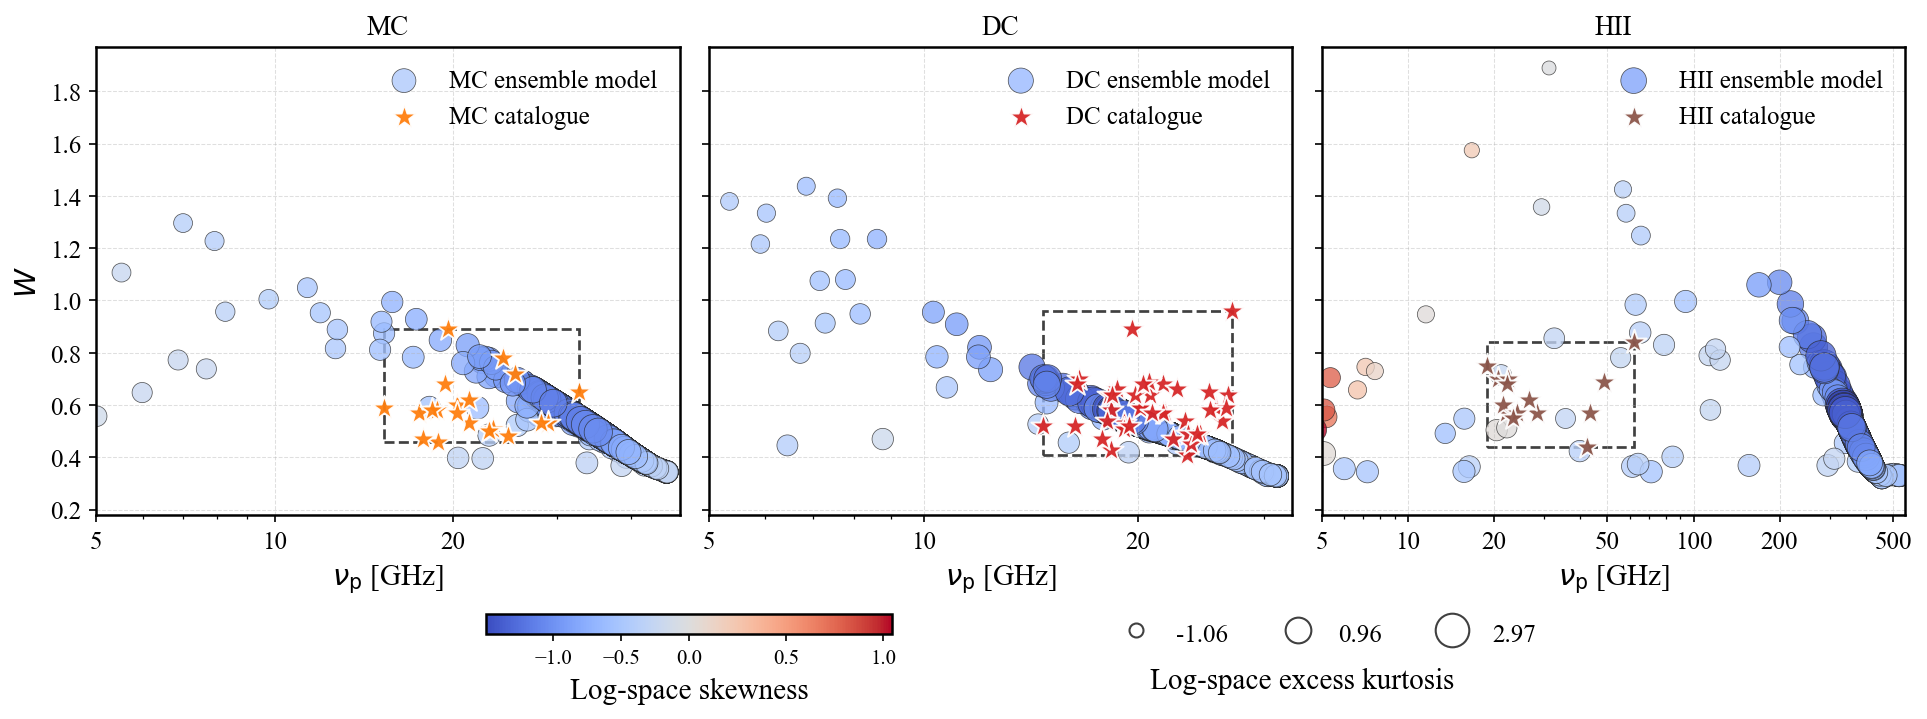

In [136]:
fig, axes = plt.subplots(1, 3, figsize=(13.4, 4.4), sharey=True)
axes = np.atleast_1d(axes)

selection_masks = {}

scatter_configs = [
    ("MC", MC_dist_ensem_features_fixed_beta_env, MC_dist_ensem_moments_fixed_beta_env, MC_catalogue, cm.tab10(0), cm.tab10(1)),
    ("DC", DC_dist_ensem_features_fixed_beta_env, DC_dist_ensem_moments_fixed_beta_env, DC_catalogue, cm.tab10(2), cm.tab10(3)),
    ("HII", HII_dist_ensem_features_fixed_beta_env, HII_dist_ensem_moments_fixed_beta_env, HII_catalogue, cm.tab10(4), cm.tab10(5)),
]

# Global ranges for consistent color and size scales
skew_all = np.concatenate([cfg[2][:, 2] for cfg in scatter_configs])
skew_finite = skew_all[np.isfinite(skew_all)]
skew_min, skew_max = np.min(skew_finite), np.max(skew_finite)
if np.isclose(skew_min, skew_max):
    skew_max = skew_min + 1e-6
if skew_min < 0 < skew_max:
    skew_norm = TwoSlopeNorm(vmin=skew_min, vcenter=0.0, vmax=skew_max)
    cmap_name = "coolwarm"
else:
    skew_norm = Normalize(vmin=skew_min, vmax=skew_max)
    cmap_name = "plasma"

kurt_all = np.concatenate([cfg[2][:, 3] for cfg in scatter_configs])
kurt_finite = kurt_all[np.isfinite(kurt_all)]
kurt_min, kurt_max = np.min(kurt_finite), np.max(kurt_finite)
if np.isclose(kurt_min, kurt_max):
    kurt_max = kurt_min + 1e-6
size_range = (45.0, 260.0)
def _scale_marker_size(values):
    finite = np.clip(values, kurt_min, kurt_max)
    return np.interp(finite, [kurt_min, kurt_max], size_range)

if np.isclose(kurt_min, kurt_max):
    size_ticks = np.array([kurt_min])
else:
    size_ticks = np.linspace(kurt_min, kurt_max, 3)

for ax, (label, ensemble_feats, ensemble_moments, catalogue_feats, ensemble_color, catalogue_color) in zip(axes, scatter_configs):
    ensemble_nu = ensemble_feats[:, 0]
    ensemble_width = ensemble_feats[:, 1]

    ensemble_skewness = ensemble_moments[:, 2]
    ensemble_kurtosis = ensemble_moments[:, 3]

    catalogue_nu = catalogue_feats[:, 0]
    catalogue_width = catalogue_feats[:, 1]

    nu_min, nu_max = catalogue_nu.min(), catalogue_nu.max()
    width_min, width_max = catalogue_width.min(), catalogue_width.max()
    rect = mpatches.Rectangle((nu_min, width_min), nu_max - nu_min, width_max - width_min,
                              facecolor="none", edgecolor="0.25", linewidth=1.3, linestyle="--", zorder=0)
    ax.add_patch(rect)

    mask = (ensemble_nu >= nu_min) & (ensemble_nu <= nu_max) & (ensemble_width >= width_min) & (ensemble_width <= width_max)
    selection_masks[label] = mask

    ensemble_sizes = _scale_marker_size(ensemble_kurtosis)
    ensemble_scatter = ax.scatter(
        ensemble_nu,
        ensemble_width,
        s=ensemble_sizes,
        c=ensemble_skewness,
        cmap=cmap_name,
        norm=skew_norm,
        alpha=0.78,
        linewidth=0.35,
        edgecolors="0.15",
        zorder=1
    )

    catalogue_scatter = ax.scatter(
        catalogue_nu,
        catalogue_width,
        s=150,
        marker="*",
        color=catalogue_color,
        edgecolors="white",
        linewidth=0.9,
        alpha=0.95,
        zorder=3
    )

    ax.set_title(f"{label}", fontsize=13)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
    ax.set_xlim(5, max(ensemble_nu.max(), catalogue_nu.max()) * 1.05)
    ax.set_xscale("log")
    ax.xaxis.set_major_locator(LogLocator(base=10, subs=(1.0, 2.0, 5.0)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda val, _: f"{val:g}" if val > 0 else ""))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(1.0, 10.0)))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xlabel(r"$\nu_{\rm p}$ [GHz]")
    ax.legend(
        [ensemble_scatter, catalogue_scatter],
        [f"{label} ensemble model", f"{label} catalogue"],
        loc="upper right",
        frameon=False
)

axes[0].set_ylabel(r"$W$")

scalar_mappable = cm.ScalarMappable(norm=skew_norm, cmap=cmap_name)
scalar_mappable.set_array([])
cbar = fig.colorbar(
    scalar_mappable,
    ax=axes,
    orientation='horizontal',
    fraction=0.04,
    pad=0.16
)
cbar.set_label("Log-space skewness", fontsize=14)
cbar.ax.tick_params(labelsize=10)

cbar_box = cbar.ax.get_position()
cbar.ax.set_position([0.10, cbar_box.y0-0.06, 0.55, cbar_box.height])

size_handles = []
for val in size_ticks:
    area = np.interp(val, [kurt_min, kurt_max], size_range)
    marker_size = np.sqrt(area)
    size_handles.append(
        Line2D([], [], marker='o', linestyle='None', markersize=marker_size,
              markerfacecolor='none', markeredgecolor='0.25', markeredgewidth=1.0, label=f"{val:.2f}")
    )
size_legend = fig.legend(
    size_handles,
    [handle.get_label() for handle in size_handles],
    loc="lower right",
    bbox_to_anchor=(0.81, 0.0),
    ncol=len(size_handles),
    columnspacing=1.6,
    frameon=False
)
fig.text(
    0.68,
    size_legend.get_bbox_to_anchor().y0 ,# 0.018,
    "Log-space excess kurtosis",
    ha='center',
    va='top',
    fontsize=14
)
for text in size_legend.get_texts():
    text.set_verticalalignment('top')
    text.set_position((-5, 15))



fig.subplots_adjust(left=0.08, right=0.98, bottom=0.23, top=0.94, wspace=0.05)


plt.savefig("obs_vs_conditional_ensemble_model.pdf", bbox_inches="tight")
plt.show()